In [1]:
library(Seurat) 
seurat = readRDS('initialseurat.RDS')

Loading required package: ggplot2

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: Matrix



In [2]:
source('../functions.R')
seurat = SubsetData(seurat, seurat@cell.names[seurat@meta.data$n_genes > 1000])
seurat = pyProcess(seurat)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Regressing out: n_genes




Time Elapsed:  34.0868229866028 secs

Scaling data matrix

Warning message:
"Python 'C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\python.exe' was requested but 'C:/Users/dmorgan/AppData/Local/r-miniconda/envs/r-reticulate/python.exe' was loaded instead (see reticulate::py_config() for more information)"


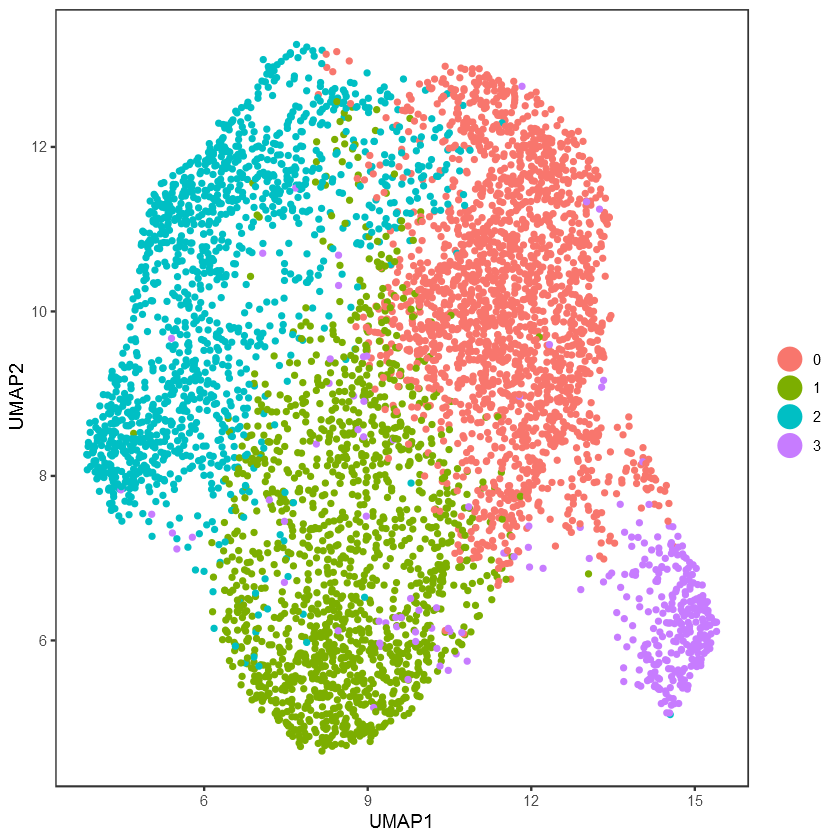

In [3]:
seurat = FindClusters(seurat, resolution = .3, dims.use = 1:20, print.output = FALSE, force.recalc = TRUE)
DimPlot(seurat, 'umap')

In [4]:
seurat = SubsetData(seurat, seurat@cell.names[seurat@ident != 3])
seurat = pyProcess(seurat)
seurat = FindClusters(seurat, resolution = .3, dims.use = 1:20, print.output = FALSE, force.recalc = TRUE)


Regressing out: n_genes




Time Elapsed:  35.3819108009338 secs

Scaling data matrix



In [5]:
source("L:/Duncan/kptumors_figures/figure_parameters.R")
Axis_themes = Axis_themes + theme(plot.title = element_text(size = 8),
                     axis.title = element_text(size = 8), 
                     axis.text = element_text(size = 6),
                     axis.text.x = element_text(size = 6),
                     legend.text = element_text(size =6),
                     legend.title = element_text(size = 8),
                     strip.text.x = element_text(size = 8), 
                     axis.line =element_line(size = .11167), 
                     axis.ticks = element_line(size = .11167)) 

UMAP_theme = theme_bw()+theme(axis.text.y = element_blank(), 
                               axis.text.x = element_blank(), 
                               axis.ticks.x= element_blank(),
                               axis.ticks.y= element_blank(),
                               axis.title.x= element_blank(),
                               axis.title.y= element_blank(),
                               strip.text.x = element_text(size = 8),
                               panel.grid.major = element_blank(),
                               panel.grid.minor = element_blank(),
                               panel.border = element_blank(),
                               panel.background = element_rect(colour = "black", fill = NA,size=.25),
                               legend.position = "none",
                               plot.title = element_text(hjust = 0.5, size = 8))

In [6]:
ngene = 50
bulk2c = read.table('bulk2c.txt', stringsAsFactors = FALSE, header = TRUE)
top_genes = bulk2c %>% filter(significant == 'yes') %>% mutate(dir = ifelse(log2.fold_change. > 0, "Up", 'Down')) %>% top_n(ngene, wt = -test_stat)
bottom_genes = bulk2c %>% filter(significant == 'yes') %>% mutate(dir = ifelse(log2.fold_change. > 0, "Up", 'Down')) %>% top_n(ngene, wt = test_stat)

seurat = AddModuleScore(seurat, list(a = top_genes$gene_id, b = bottom_genes$gene_id))

Loading required package: magrittr


Attaching package: 'ggpubr'


The following object is masked from 'package:cowplot':

    get_legend




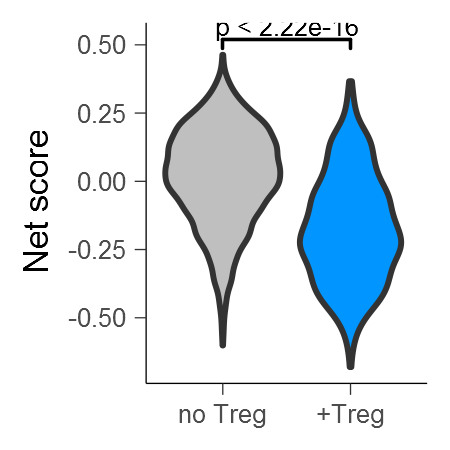

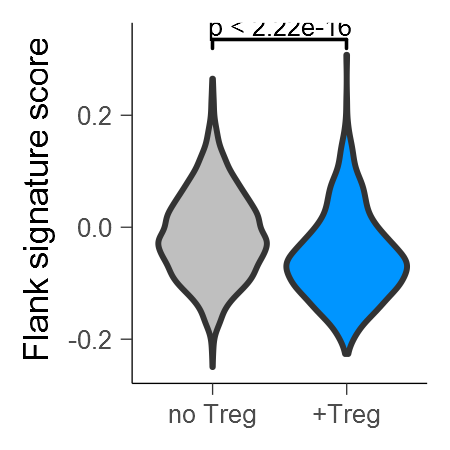

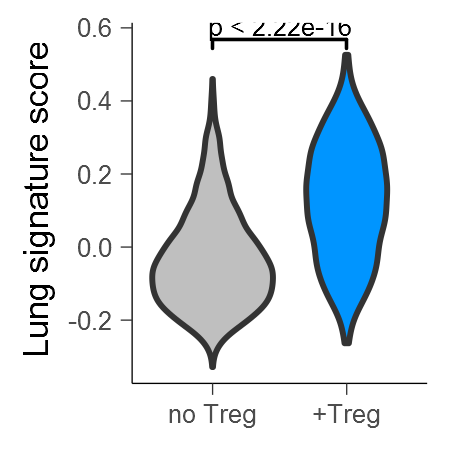

In [7]:
library(ggpubr)
options(repr.plot.res = 300, repr.plot.height = 1.5, repr.plot.width =1.5 )

seurat@meta.data$condition = ifelse(seurat@meta.data$orig == "AE3", '+Treg', 'no Treg')
pal = c('#0095FF', '#BFBFBF')
names(pal) = c('+Treg', 'no Treg')
seurat@meta.data$condition = factor(seurat@meta.data$condition, levels =c ('no Treg', '+Treg'))
g1 = ggplot(seurat@meta.data, aes(x =condition, y = Cluster1-Cluster2, fill = condition)) + geom_violin() + stat_compare_means(comparison = list(c(1,2))) + labs(y = 'Net score', x = c()) + 
scale_fill_manual(values = pal) + guides(fill = FALSE) + theme_classic() + Axis_themes
g1$layers[[2]]$aes_params$textsize <- 2.1167
g1

g2 = ggplot(seurat@meta.data, aes(x =condition, y = Cluster1, fill = condition)) + geom_violin() + stat_compare_means(comparison = list(c(1,2)))  + labs(y = 'Flank signature score', x = c()) + 
scale_fill_manual(values = pal) + guides(fill = FALSE) + theme_classic() + Axis_themes
g2$layers[[2]]$aes_params$textsize <- 2.1167
g2


g3 = ggplot(seurat@meta.data, aes(x =condition, y = Cluster2, fill = condition)) + geom_violin() + stat_compare_means(comparison = list(c(1,2)))  + labs(y = 'Lung signature score', x = c()) + 
scale_fill_manual(values = pal) + guides(fill = FALSE) + theme_classic() + Axis_themes
g3$layers[[2]]$aes_params$textsize <- 2.1167
g3


In [8]:
seurat = SetAllIdent(seurat, 'orig')
a = FindMarkers(seurat, 'AE3', logfc.threshold = 0)
head(a, 5)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S1pr1,8.485113e-121,0.8776849,0.588,0.210,1.246548e-116
Hsp90ab1,3.641496e-109,-0.5490332,0.942,0.994,5.349722e-105
Atp5b,6.931842e-101,-0.5549850,0.825,0.971,1.018357e-96
Cd7,4.189489e-100,0.4742415,0.242,0.031,6.154778e-96
Gzmb,5.501683e-100,-1.2845700,0.230,0.683,8.082522e-96


In [9]:
write.csv(a, 'volcano_markers.csv')


   0    1    2    3 
3948  644 1853  585 

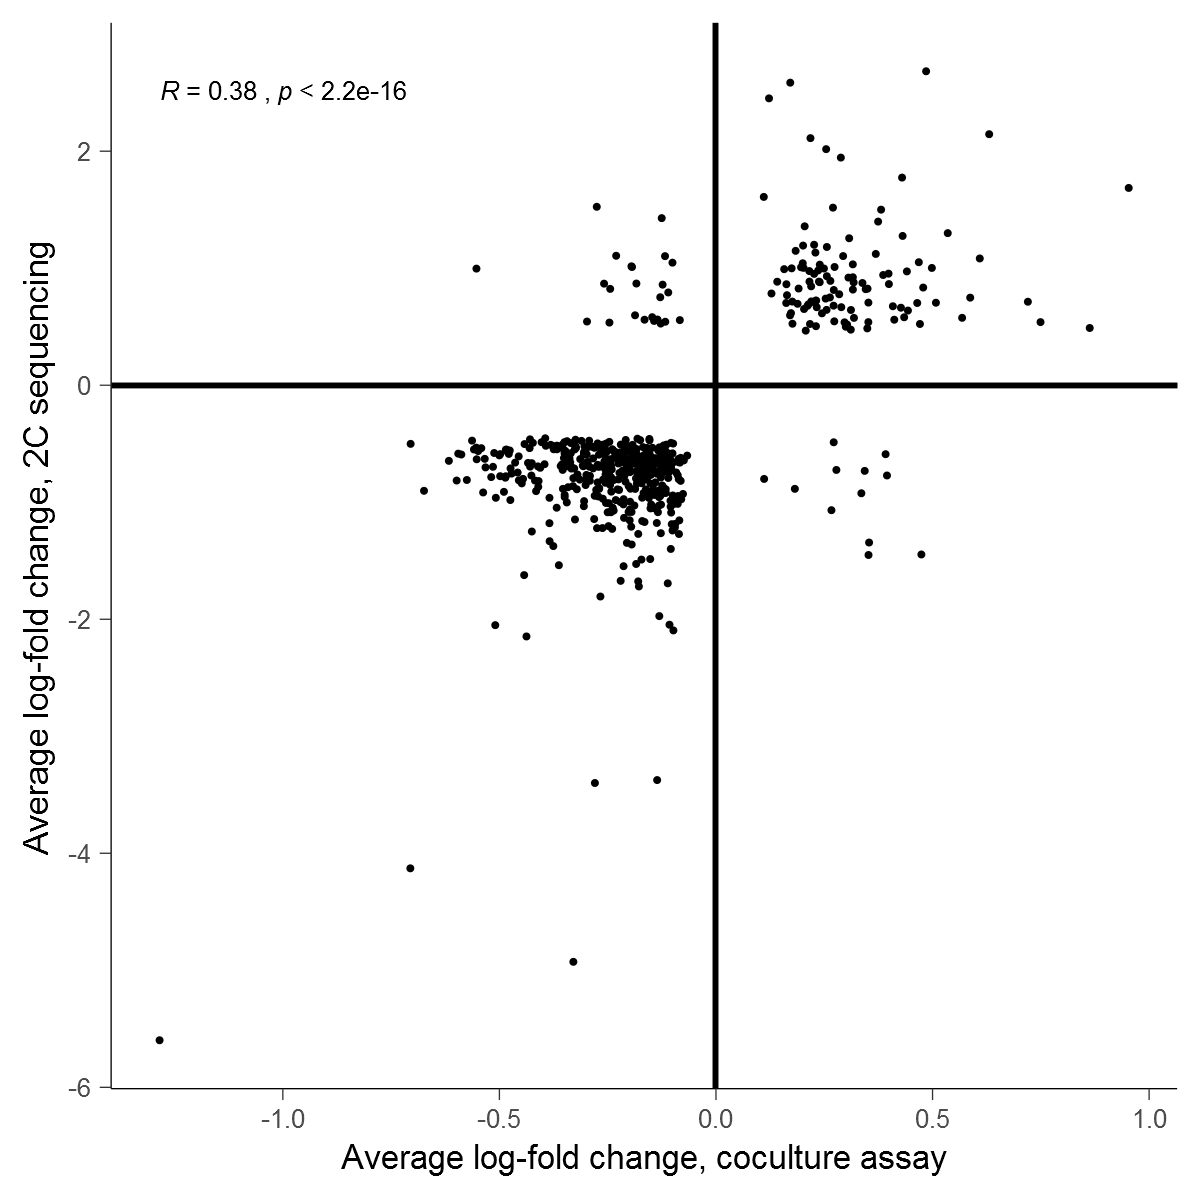

In [10]:
rownames(bulk2c) = bulk2c$gene
options(repr.plot.res = 300, repr.plot.height = 4, repr.plot.width =4)

a$otherlog = bulk2c[rownames(a), 'log2.fold_change.']
a$othersig = bulk2c[rownames(a), 'significant']

a$sig = 2*(as.numeric(a$p_val_adj < 1e-2)) + (a$othersig == 'yes')
table(a$sig)
a$gene = rownames(a)
g4 = ggplot(a %>% filter(!is.na(otherlog), !is.na(avg_logFC), sig == 3), aes(x = avg_logFC, y = otherlog, label = gene)) + geom_point(size = .01) + stat_cor(method = 'spearman', size = 2.1167) + theme_classic() +
geom_vline(aes(xintercept = 0), color = 'black') + geom_hline(aes(yintercept = 0))+
labs(x = c('Average log-fold change, coculture assay'), y = 'Average log-fold change, 2C sequencing') + 
scale_color_manual(values = c('grey95', 'red', 'blue', 'purple')) + Axis_themes
g4


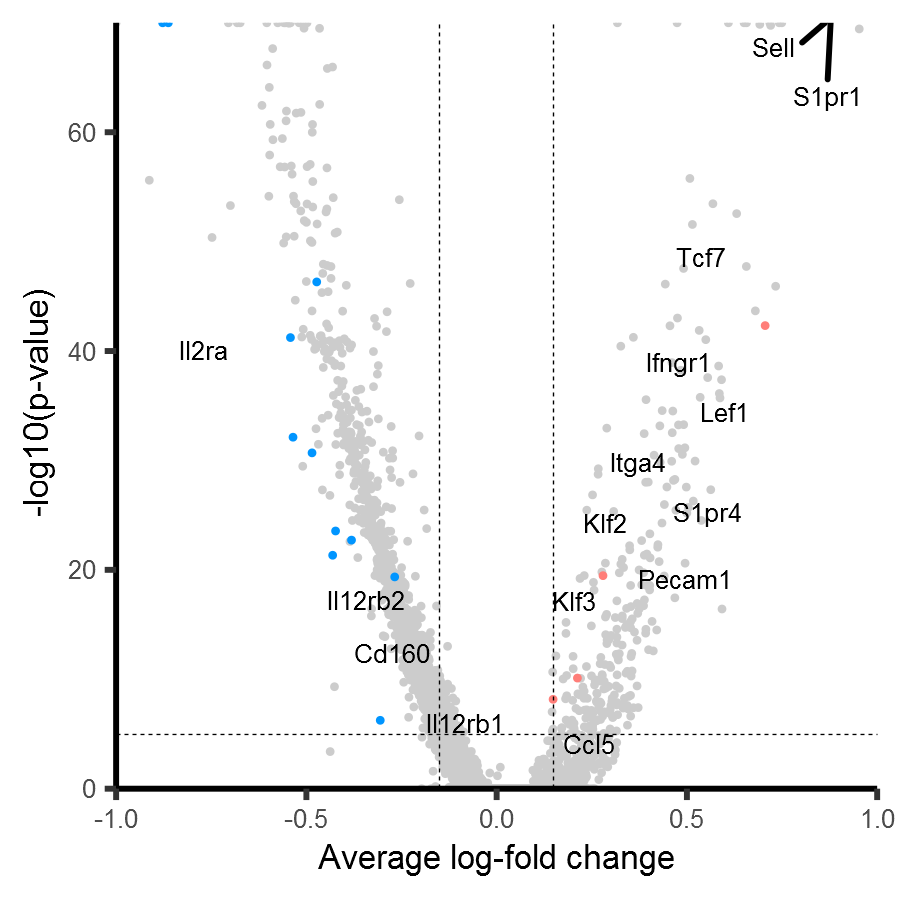

In [11]:
library(ggrepel)

source("L:/Duncan/kptumors_figures/figure_parameters.R")
tissue_palette = c('#FF2600', '#FF7E79', '#0433FF', '#0095FF')

options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 300)
genes.to.label = c('Bzmb', 'S1pr1', 'Sell', 'Il2ra', 'Il12rb2', 'Cd160', 'Il12rb1', 'Tcf7', 'Ifngr1', 'Lef1', 'Itga4', 'Klf2', 'Klf3', 'S1pr4', 'Pecam1', 'Ccl5')
volcano_markers = a
volcano_markers$gene = rownames(volcano_markers)
volcano_markers$gene[!rownames(volcano_markers) %in% genes.to.label] = NA
volcano_markers$color = 'a'
volcano_markers$color[!is.na(volcano_markers$gene) & volcano_markers$avg_logFC > 0] = 'b'
volcano_markers$color[!is.na(volcano_markers$gene) & volcano_markers$avg_logFC < 0] = 'c'

volcano_markers$pval_plot = ifelse(volcano_markers$p_val_adj < 1e-70, 1e-70, volcano_markers$p_val_adj)
volcano_markers$avg_logFC_plot = volcano_markers$avg_logFC
volcano_markers$avg_logFC_plot[volcano_markers$avg_logFC > 1] = 1
volcano_markers$avg_logFC_plot[volcano_markers$avg_logFC < -1] = -1

g5 = ggplot(volcano_markers %>% filter(is.na(gene)), aes(x = avg_logFC_plot, y = -log10(pval_plot), color = color)) + geom_point(size = .1) + 
geom_point(data = volcano_markers %>% filter(!is.na(gene)),  aes(x = -avg_logFC_plot, y = -log10(pval_plot), color = color), size = .1) + 
geom_text_repel(data = volcano_markers %>% filter(!is.na(gene)), aes(label = gene), size = 2.1167, color = 'black') + 
theme_classic() + Axis_themes + guides(color = FALSE) + scale_x_continuous(limits = c(-1, 1), expand = c(0,0)) + 
scale_color_manual(values = c('grey80', tissue_palette[4], tissue_palette[2])) + scale_y_continuous(expand = c(0,0)) + 
geom_hline(yintercept = 5, linetype = 'dashed', size = .1167) + geom_vline(xintercept = .15, linetype = 'dashed', size = .1167) + 
geom_vline(xintercept = -.15, linetype = 'dashed', size = .1167) + labs(x = 'Average log-fold change', y = '-log10(p-value)')

g5